# Automated model selection in scikit-learn
***

In [135]:
import os
from zipfile import ZipFile
from six.moves import urllib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (balanced_accuracy_score, classification_report,
                             auc, plot_confusion_matrix, plot_roc_curve
                             
%matplotlib inline

***
## Define custom transformers

In [136]:

class FeatureSelector(BaseEstimator,TransformerMixin):
    #creates a new dataframe using only columns listed in attribute_names
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, dataframe, y=None):#fit does nothing since we're defining a tranformer
        return self                  #y=None ensures the output of the fit method has correct shape
    
    def transform(self, dataframe):
        return dataframe[self.attribute_names].values

    
class CountWords(BaseEstimator,TransformerMixin):
    #creates a dataframe from a series by using the Series.apply() method.
    def __init__(self,new_col_name):
        self.new_col_name = new_col_name
        
    def fit(self,series,y=None):
        return self 
    
    def transform(self,series):
        n_words_col = series.apply(lambda x: len(x.split(' '))).rename(self.new_col_name)
        return pd.concat([series, n_words_col], axis=1)

    
class MeanWordLength(BaseEstimator,TransformerMixin):
    #creates a column mean length of words in message 
    def __init__(self,text_column):
        self.text_column = text_column
                                                                 
    def fit(self,dataframe,y=None):
        return self 
    
    def transform(self,dataframe):
        dataframe['mean_word_length'] = dataframe[self.text_column].apply(lambda x:
                                                                          sum(map(len,x.split(' ')))/len(x.split(' ')))
        return dataframe

***
## Define some convenience functions 

In [137]:
#function to conveniently display model performance 
def performance_summary(y_test,predictions,pipeline):
    print(classification_report(y_test, predictions))
    print('Balanced accuracy = {:.2f}'.format(balanced_accuracy_score(y_test,predictions)))
    plot_confusion_matrix(pipeline,X_test,y_test)
    plot_roc_curve(pipeline,X_test,y_test)

In [175]:
#optional funcion which you can use to download and unzip data from the UCI machine learning repo
DOWNLOAD_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
STORE_PATH = os.path.join("/project/experimental_models/data")
FILE_NAME =  "SMS.zip"

def download_data_from_zip(url=DOWNLOAD_URL, dir_path=STORE_PATH):
    
    #Check if target directory exists. If not, create it. 
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    #Retive and and unpack the download to dir_path
    download_path = os.path.join(dir_path, FILE_NAME)
    urllib.request.urlretrieve(url, download_path)
    SMS_PATH = os.path.join(STORE_PATH,FILE_NAME)
    with ZipFile(SMS_PATH, 'r') as zip_ref:
        zip_ref.extractall(dir_path)
    
download_data_from_zip()

***
## Load data

In [176]:
columns = ['label','text']
data = pd.read_csv("SMSSpamCollection", names=columns, delimiter='\t')

In [177]:
data.dtypes

label    object
text     object
dtype: object

In [178]:
X, y = data['text'], data['label']

***
## Build the pipeline

In [157]:
#define text and numerical features
text_features = 'text'
numerical_features = ['n_words','mean_word_length']

In [158]:
pipeline1 = Pipeline([('n_words',CountWords('n_words')),
                      ('mean_length',MeanWordLength('text'))])

In [159]:
num_pipeline = Pipeline([('selector',FeatureSelector(numerical_features)),
                         ('imp',SimpleImputer())])

composite_transform = ColumnTransformer([
        ("txt", CountVectorizer(), 'text'),
        ("num", num_pipeline,['n_words','mean_word_length']),
    ])

In [160]:
pipeline = Pipeline([('add_numerical',pipeline1),
                     ('transform',composite_transform),
                     ('clf',SVC())])

In [161]:
#visualise pipeline
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context
pipeline  

Pipeline(steps=[('add_numerical',
                 Pipeline(steps=[('n_words',
                                  CountWords(new_col_name='n_words')),
                                 ('mean_length',
                                  MeanWordLength(text_column='text'))])),
                ('transform',
                 ColumnTransformer(transformers=[('txt', CountVectorizer(),
                                                  'text'),
                                                 ('num',
                                                  Pipeline(steps=[('selector',
                                                                   FeatureSelector(attribute_names=['n_words',
                                                                                                    'mean_word_length'])),
                                                                  ('imp',
                                                                   SimpleImputer())]),
                                                  ['n_words',
                                                   'mean_word_length'])])),
                ('clf', SVC())])

***
## Perform train-test split

In [162]:
X, y = data['text'], data['label']
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

***
## Make a prediction

In [163]:
pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)

              precision    recall  f1-score   support

         ham       0.96      0.99      0.98      1448
        spam       0.94      0.72      0.82       224

    accuracy                           0.96      1672
   macro avg       0.95      0.86      0.90      1672
weighted avg       0.96      0.96      0.95      1672

Balanced accuracy = 0.86


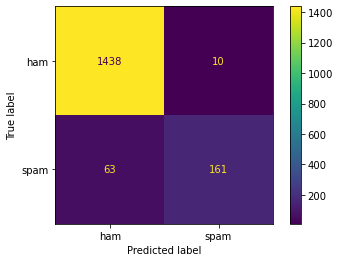

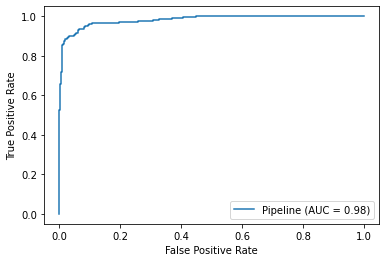

In [164]:
performance_summary(y_test,predictions,pipeline)

***
## Set-up hyperparameter space and perform grid search

In [165]:
print(pipeline.get_params().keys())
print('\n Number of hyperparameter: {}'.format(len(pipeline.get_params().keys())))

dict_keys(['memory', 'steps', 'verbose', 'add_numerical', 'transform', 'clf', 'add_numerical__memory', 'add_numerical__steps', 'add_numerical__verbose', 'add_numerical__n_words', 'add_numerical__mean_length', 'add_numerical__n_words__new_col_name', 'add_numerical__mean_length__text_column', 'transform__n_jobs', 'transform__remainder', 'transform__sparse_threshold', 'transform__transformer_weights', 'transform__transformers', 'transform__verbose', 'transform__txt', 'transform__num', 'transform__txt__analyzer', 'transform__txt__binary', 'transform__txt__decode_error', 'transform__txt__dtype', 'transform__txt__encoding', 'transform__txt__input', 'transform__txt__lowercase', 'transform__txt__max_df', 'transform__txt__max_features', 'transform__txt__min_df', 'transform__txt__ngram_range', 'transform__txt__preprocessor', 'transform__txt__stop_words', 'transform__txt__strip_accents', 'transform__txt__token_pattern', 'transform__txt__tokenizer', 'transform__txt__vocabulary', 'transform__num__m

In [166]:
params = {
    'transform__txt__max_features': [None,100,10],
    'transform__num__selector__attribute_names': [['n_words'],
                                                  ['mean_word_length'],
                                                  ['n_words','mean_word_length']]  
}

In [167]:
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(pipeline, params,scoring='balanced_accuracy',cv=5)
model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('add_numerical',
                                        Pipeline(steps=[('n_words',
                                                         CountWords(new_col_name='n_words')),
                                                        ('mean_length',
                                                         MeanWordLength(text_column='text'))])),
                                       ('transform',
                                        ColumnTransformer(transformers=[('txt',
                                                                         CountVectorizer(),
                                                                         'text'),
                                                                        ('num',
                                                                         Pipeline(steps=[('selector',
                                                                                          FeatureSelector(attribute_names=['n_words',
                                                                                                                           'mean_word_length'])),
                                                                                         ('imp',
                                                                                          SimpleImputer())]),
                                                                         ['n_words',
                                                                          'mean_word_length'])])),
                                       ('clf', SVC())]),
             param_grid={'transform__num__selector__attribute_names': [['n_words'],
                                                                       ['mean_word_length'],
                                                                       ['n_words',
                                                                        'mean_word_length']],
                         'transform__txt__max_features': [None, 100, 10]},
             scoring='balanced_accuracy')

In [168]:
model.cv_results_

{'mean_fit_time': array([0.60880451, 0.35844369, 0.24011493, 0.61460299, 0.28548241,
        0.23398905, 0.56544514, 0.31399813, 0.19260459]),
 'std_fit_time': array([0.03681248, 0.04303   , 0.00273188, 0.04893746, 0.04536344,
        0.00252456, 0.04274611, 0.00449362, 0.0024536 ]),
 'mean_score_time': array([0.14649725, 0.0769299 , 0.05288291, 0.14684415, 0.07781267,
        0.07103724, 0.12105517, 0.07810111, 0.06671948]),
 'std_score_time': array([0.03888903, 0.00141096, 0.00068443, 0.04068818, 0.0419757 ,
        0.03964245, 0.00432439, 0.00723863, 0.04003522]),
 'param_transform__num__selector__attribute_names': masked_array(data=[list(['n_words']), list(['n_words']),
                    list(['n_words']), list(['mean_word_length']),
                    list(['mean_word_length']), list(['mean_word_length']),
                    list(['n_words', 'mean_word_length']),
                    list(['n_words', 'mean_word_length']),
                    list(['n_words', 'mean_word_length']

In [169]:
#print the mean scores
model.cv_results_['mean_test_score']

array([0.89959483, 0.85814359, 0.57385501, 0.94243247, 0.90895169,
       0.64998269, 0.91271499, 0.89594222, 0.81483886])

In [170]:
#print the parameter names 
model.cv_results_['params']

[{'transform__num__selector__attribute_names': ['n_words'],
  'transform__txt__max_features': None},
 {'transform__num__selector__attribute_names': ['n_words'],
  'transform__txt__max_features': 100},
 {'transform__num__selector__attribute_names': ['n_words'],
  'transform__txt__max_features': 10},
 {'transform__num__selector__attribute_names': ['mean_word_length'],
  'transform__txt__max_features': None},
 {'transform__num__selector__attribute_names': ['mean_word_length'],
  'transform__txt__max_features': 100},
 {'transform__num__selector__attribute_names': ['mean_word_length'],
  'transform__txt__max_features': 10},
 {'transform__num__selector__attribute_names': ['n_words', 'mean_word_length'],
  'transform__txt__max_features': None},
 {'transform__num__selector__attribute_names': ['n_words', 'mean_word_length'],
  'transform__txt__max_features': 100},
 {'transform__num__selector__attribute_names': ['n_words', 'mean_word_length'],
  'transform__txt__max_features': 10}]

In [53]:
#reshape into a grid, rows are arributes, cols are max_features 
results = model.cv_results_['mean_test_score'].reshape(3,3)
results

array([[0.88517219, 0.84387782, 0.56265842],
       [0.93578592, 0.90283972, 0.61507371],
       [0.89769976, 0.87921507, 0.8192578 ]])

<IPython.core.display.Javascript object>


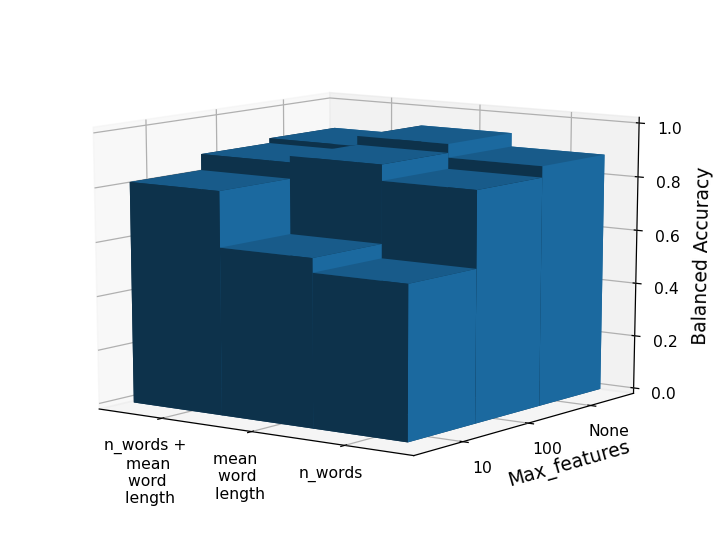

In [65]:
#%matplotlib notebook #uncomment this line to make plot interactive
from mpl_toolkits.mplot3d import Axes3D

#setup grid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array([[i]*3 for i in range(3)]).ravel() # x coordinates of each bar
y = np.array([i for i in range(3)]*3) # y coordinates of each bar
z = np.zeros(9) # z coordinates of each bar
dx = np.ones(9) # length along x-axis of each bar
dy = np.ones(9) # length along y-axis of each bar
dz = results.ravel() # length along z-axis of each bar (height)
#dx = np.array([0.5]*9)
ax.bar3d(x, y, z, dx, dx, dz)
ax.set_zlim3d(0,1)
ax.view_init(elev=12, azim=120)
ax.set_xticks([0.5,1.5,2.5])
ax.set_yticks([0.5,1.5,2.5])
ax.set_xticklabels(['n_words','mean \n word \n length','n_words + \n mean \n word \n length'])
ax.set_yticklabels(['None','100','10'])

#ax.set_xlabel('Columns', fontsize=14, rotation=150)
ax.set_ylabel('Max_features', fontsize=12)
ax.set_zlabel('Balanced Accuracy', fontsize=12, rotation=60)
plt.tight_layout()
plt.savefig('grid_search.png',dpi=300)


In [171]:
print('Best params:', model.best_params_)
print('Best score:',model.best_score_)
print('Score function:', model.scorer_)

Best params: {'transform__num__selector__attribute_names': ['mean_word_length'], 'transform__txt__max_features': None}
Best score: 0.9424324692401616
Score function: make_scorer(balanced_accuracy_score)


***
## Use best model to predict on the test set 

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       0.98      0.85      0.91       224

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672

Balanced accuracy = 0.92


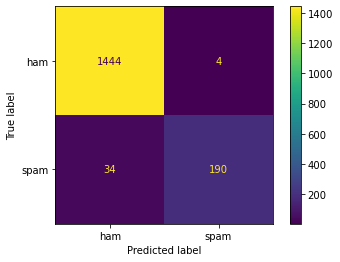

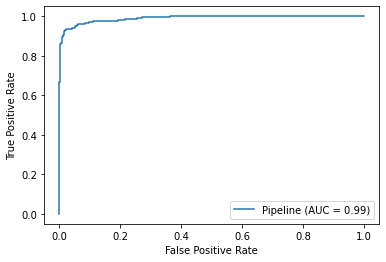

In [172]:
best_model = model.best_estimator_
predictions = best_model.predict(X_test)
performance_summary(y_test,predictions,best_model)